In [1]:
!pip install -U git+https://github.com/k-wib/sdr.git
!pip install -U sliced

  Cloning https://github.com/k-wib/sdr.git to /tmp/pip-req-build-zve7f61l
  Running command git clone -q https://github.com/k-wib/sdr.git /tmp/pip-req-build-zve7f61l
     |████████████████████████████████| 776.8 MB 19 kB/s 
  Created wheel for sdr: filename=sdr-1.0.0-py3-none-any.whl size=4058 sha256=ad59f834a70b3b59b23d7be6a1d67ba55ce70cab8e28ec6b63c4868766be5e73
  Stored in directory: /tmp/pip-ephem-wheel-cache-on_qjmh3/wheels/09/cf/31/a8da759b8a42b1bfac87e3d84dd4d487720b5e502e38775713
Successfully built sdr
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, bu

In [3]:
from sdr import *
from sliced import SlicedInverseRegression, SlicedAverageVarianceEstimation
from sklearn import mixture, datasets
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV

from sklearn.feature_selection import VarianceThreshold

random_seed=42

%config InlineBackend.figure_format = 'retina'

In [4]:
from numpy import eye, asarray, dot, sum, diag
from numpy.linalg import svd

def varimax(Phi, gamma = 1.0, q = 20, tol = 1e-6):
    p,k = Phi.shape
    R = eye(k)
    d=0
    for i in range(q):
        d_old = d
        Lambda = dot(Phi, R)
        u,s,vh = svd(dot(Phi.T,asarray(Lambda)**3 - (gamma/p) * dot(Lambda, diag(diag(dot(Lambda.T,Lambda))))))
        R = dot(u,vh)
        d = sum(s)
        if d_old!=0 and d/d_old < 1 + tol: break
    return dot(Phi, R)

# Experiment 1

In [5]:
X,y=datasets.make_friedman1(n_samples=5000, n_features=15, noise=0)
X=X-np.mean(X,axis=0)
Z=np.hstack((X,y.reshape(-1,1)))

X.shape, y.shape

((5000, 15), (5000,))

## SDR

In [6]:
gmm_fit = NormalMixFit(num_comps=[2,5,10,15], covariance_type='full', criterion='aic', random_state=random_seed)
gmm_fit.get_gmm(X, y)

gmm_fit.fitted_gmm

GaussianMixture(n_components=10, random_state=42)

In [10]:
B=2*10**5
p=5

sdr_model = SDR(n=B, n_lb=B, p=p, eta=10, epochs=500, stoc=True, algo="cayley", early_stopping=50)
sdr_model.fit(gmm_fit.fitted_gmm)

 53%|█████▎    | 265/500 [03:00<02:40,  1.47it/s]


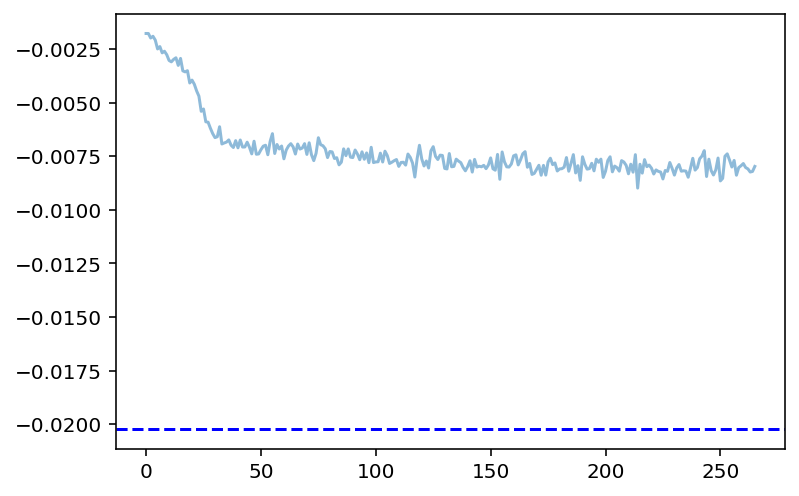

In [11]:
sdr_model.plot()

## SIR

In [12]:
sir = SlicedInverseRegression(n_directions=p)
sir.fit(X, y)
A2=sir.directions_

## SAVE

In [13]:
save = SlicedAverageVarianceEstimation(n_directions=p)
save.fit(X, y)
A3=save.directions_

## PCA

In [14]:
V,U=np.linalg.eigh(np.cov(X.T))
U=U[:,::-1]
U=U[:,:p]

## Plots

In [15]:
O=np.array([#np.abs(sdr_model.A.detach().numpy()).tolist(),
            np.abs(varimax(sdr_model.A.detach().numpy().T)).T.tolist(),
            #np.abs(A2).tolist(),
            np.abs(varimax(A2.T).T).tolist(),
            #np.abs(A3).tolist(),
            np.abs(varimax(A3.T).T).tolist(),
            #np.abs(U.T).tolist(),
            np.abs(varimax(U).T).tolist()])
O.shape

(4, 5, 15)

In [16]:
titles=[['GMM SDR','\nSIR'],['SAVE','\nPCA']]

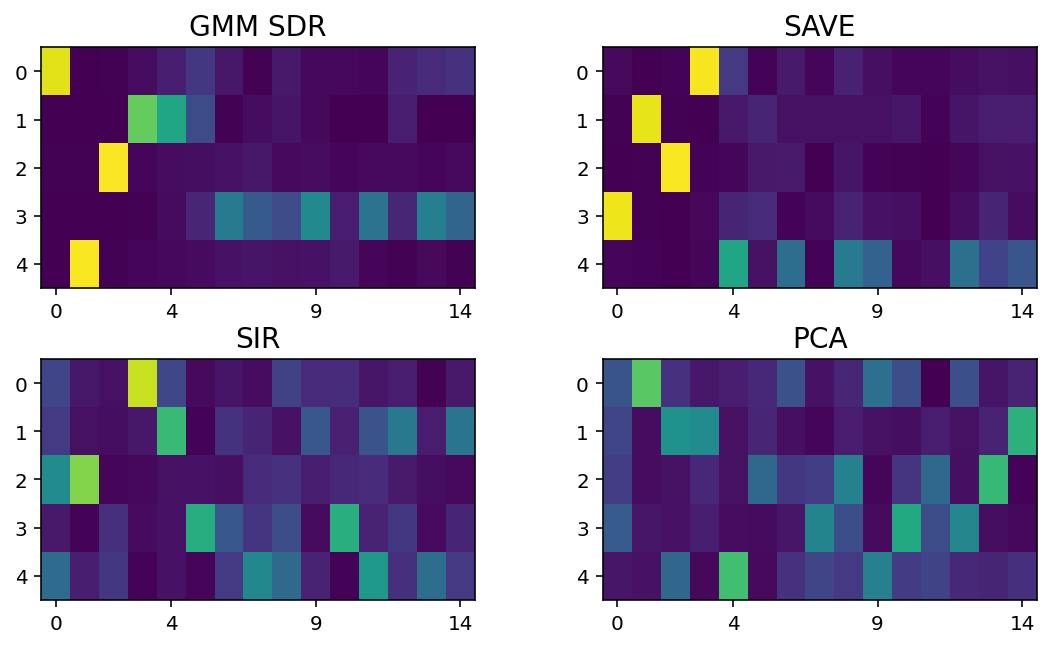

In [18]:
fig, axs = plt.subplots(2,2)
fig.tight_layout()

cont=0

for j in range(2):
    for i in range(2):
        
        im=axs[i,j].imshow(O[cont], cmap='viridis', vmin=0, vmax=1, aspect='auto')
        axs[i,j].set_title(titles[j][i], size=14)
        #axs[i,j].set_xlabel('Input', size=12)
        #axs[i,j].set_ylabel('Output', size=12)

        ticks=[0,4,9,14]
        #labels=np.round(np.array(values[j]), 3)[ticks]
        axs[i,j].set_xticks(ticks)
        #axs[i,j].set_xticklabels('Input dimensions', size=14)
        #axs[i,j].set_yticks(ticks)
        #axs[i,j].set_yticklabels('Output dimensions', size=14)
        
        cont+=1
 
#cbar = fig.colorbar(im, ax=axs.ravel().tolist(),aspect=30,fraction=0.02, pad=0.04)
#cbar.ax.tick_params(labelsize=12)
#cbar.ax.set_title('',size=12)

fig.set_figheight(4.5)
fig.set_figwidth(8)
#plt.savefig('plots/sdr_pca.png', bbox_inches='tight', dpi=500, transparent=True)
plt.show()

# Experiment 2

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
%cd /content/drive/My Drive/

/content/drive/My Drive


In [50]:
from sklearn.preprocessing import StandardScaler

def load_dataset(name):
    #Separator#
    if name in ['bank32nh', 'bank8FM','puma8NH','fried_delve', 'delta_ailerons']: sep=" "
    elif name in ['winequality']: sep=";"
    else: sep=","
    ###########
    
    #.data
    #url="https://raw.githubusercontent.com/felipemaiapolo/master_thesis/master/open_datasets/"+name+".data"
    #s=requests.get(url).content
    d1=pd.read_csv("data/"+name+".data", header=None, sep=sep)
    #.test
    #url="https://raw.githubusercontent.com/felipemaiapolo/master_thesis/master/open_datasets/"+name+".test"
    #s=requests.get(url).content
    try:
        d2=pd.read_csv("data/"+name+".test", header=None, sep=sep)
        d1=d1.append(d2)
        print("- ***",name,"*** dataset shape=",np.shape(d1)) #Printing shape of dataset
        
        #### exception
        if name in ['bank32nh','bank8FM','puma8NH']:d1=d1.iloc[:,:-1]
        else: pass
        ####
        
        return d1.dropna()
    except:
        print("- ***",name,"*** dataset shape=",np.shape(d1)) #Printing shape of dataset
        
        #### exception
        if name in ['bank32nh','bank8FM','puma8NH']:d1=d1.iloc[:,:-1]
        else: pass
        return d1.dropna()
    
    
def get_X_y(pd_df,scale=True):
    if scale: 
        scaler=StandardScaler()
        scaled=scaler.fit_transform(np.array(pd_df))
        X=scaled[:,:-1]
        y=scaled[:,-1]
    else:
        X=np.array(pd_df)[:,:-1]
        y=np.array(pd_df)[:,-1]
    return [X,y]


In [51]:
dataset_names=['abalone','bank32nh','cal_housing','cpu_act','delta_ailerons',
               'elevators', 'fried_delve','puma32H'] 

In [66]:
import pandas as pd

In [67]:
data={}
for name in dataset_names: data[name]=load_dataset(name) 

- *** abalone *** dataset shape= (4177, 9)
- *** bank32nh *** dataset shape= (8192, 34)
- *** cal_housing *** dataset shape= (20640, 9)
- *** cpu_act *** dataset shape= (8192, 22)
- *** delta_ailerons *** dataset shape= (7129, 6)
- *** elevators *** dataset shape= (16599, 19)
- *** fried_delve *** dataset shape= (40768, 11)
- *** puma32H *** dataset shape= (8192, 33)


In [68]:
for name in dataset_names: 
    n = data[name].shape[0]
    index = np.random.choice(n, min(10000,n), replace=False)
    data[name]=data[name].iloc[index,:]

In [69]:
#Exclude categorical variable
data['abalone']=data['abalone'].iloc[:,1:]

In [70]:
for name in dataset_names: data[name]=get_X_y(data[name], scale=False)

In [71]:
# for name in dataset_names:
#     data[name][0]=VarianceThreshold(threshold=0.).fit_transform(data[name][0])
    
#     n,d=data[name][0].shape
    
#     if d<15:
#         data[name][0]=np.hstack((data[name][0], np.random.normal(0,1,n*(15-d)).reshape((n,-1))))

In [72]:
for name in dataset_names: 
    scaler=StandardScaler()
    data[name][0]=scaler.fit_transform(data[name][0])
    
    scaler=StandardScaler()
    data[name][1]=scaler.fit_transform(data[name][1].reshape((-1,1))).squeeze()
    print(name,data[name][0].shape)

abalone (4177, 7)
bank32nh (8192, 32)
cal_housing (10000, 8)
cpu_act (8192, 21)
delta_ailerons (7129, 5)
elevators (10000, 18)
fried_delve (10000, 10)
puma32H (8192, 32)


In [73]:
p=1
B=10**5

In [74]:
from sklearn.feature_selection import mutual_info_regression

In [75]:
from scipy import stats


abalone


  8%|▊         | 775/10000 [03:16<38:53,  3.95it/s]


bank32nh


  9%|▉         | 911/10000 [03:25<34:13,  4.43it/s]


cal_housing


 13%|█▎        | 1288/10000 [05:03<34:12,  4.24it/s]


cpu_act


  9%|▉         | 931/10000 [04:18<42:00,  3.60it/s]


delta_ailerons


  5%|▌         | 507/10000 [01:23<26:08,  6.05it/s]


elevators


  1%|          | 123/10000 [00:24<32:43,  5.03it/s]


fried_delve


  1%|          | 64/10000 [00:15<39:43,  4.17it/s]


puma32H


  1%|▏         | 142/10000 [00:20<23:23,  7.03it/s]


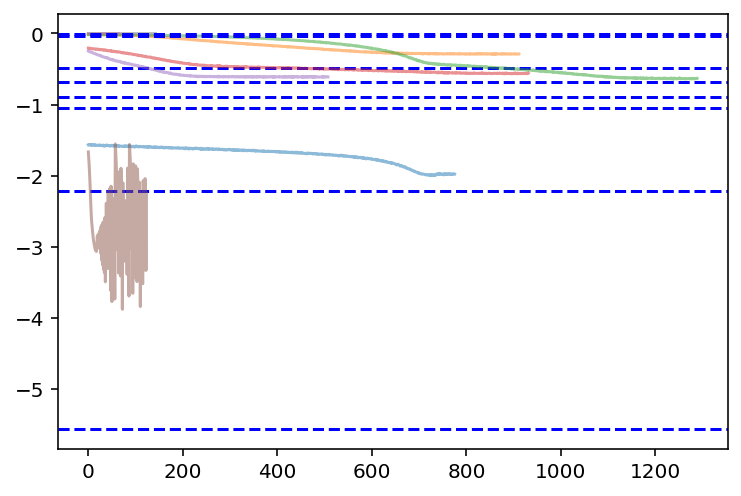

In [77]:
results=[]

for name in dataset_names: 
    
    print(name)
    
    X,y=data[name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

    results.append([])
    
    ##GMM SDR
    gmm_fit = NormalMixFit(num_comps=[3,5,7,10,15], covariance_type='full', criterion='aic', reg_covar=1e-05, random_state=random_seed)
    gmm_fit.get_gmm(X_train, y_train)
    #mouli = CayleyArmijo(rho_1 = 0.1, rho_2 = 0.9, max_iter = 10)
    #sdr_model = SDR(n=B, n_lb=B, p=p, eta=1, epochs=500, stoc=True, algo=mouli, early_stopping=50)
    
    gmm_fit = NormalMixFit(num_comps=[3,5,7,10,15], covariance_type='full', criterion='aic', reg_covar=1e-05, random_state=random_seed)
    gmm_fit.get_gmm(X_train, y_train)
    sdr_model = SDR(n=B, n_lb=B, p=p, eta=.01, epochs=10000, stoc=True, algo="cayley", early_stopping=50)
    save = SlicedAverageVarianceEstimation(n_directions=p)
    save.fit(X_train, y_train)
    A=save.directions_
    sdr_model.fit(gmm_fit.fitted_gmm)
    A=sdr_model.A.detach().numpy()
    results[-1].append(abs(list(stats.spearmanr((X_test@A.T).squeeze(), y_test))[0]))
    sdr_model.plot()

    ##SIR
    sir = SlicedInverseRegression(n_directions=p)
    sir.fit(X_train, y_train)
    A=sir.directions_
    results[-1].append(abs(list(stats.spearmanr((X_test@A.T).squeeze(), y_test))[0]))

    ##SAVE
    save = SlicedAverageVarianceEstimation(n_directions=p)
    save.fit(X_train, y_train)
    A=save.directions_
    results[-1].append(abs(list(stats.spearmanr((X_test@A.T).squeeze(), y_test))[0]))

    ##PCA
    _,A=np.linalg.eigh(np.cov(X_train.T))
    A=A[:,::-1]
    A=A[:,:p].T
    results[-1].append(abs(list(stats.spearmanr((X_test@A.T).squeeze(), y_test))[0]))

    ##RAW
    #reg = RidgeCV().fit(X_train, y_train)
    #results[-1].append(np.sqrt(np.mean((reg.predict(X_test)- y_test)**2)))
    

In [78]:
results=np.array(results)
results

array([[0.39828201, 0.74044798, 0.23549091, 0.64522737],
       [0.05425748, 0.76721799, 0.21022563, 0.09624619],
       [0.19729049, 0.82708713, 0.73204208, 0.0924815 ],
       [0.15418104, 0.9147507 , 0.56399753, 0.87719512],
       [0.72353785, 0.81748528, 0.8203911 , 0.54397294],
       [0.49282871, 0.74704313, 0.74653157, 0.45711047],
       [0.04086614, 0.83982942, 0.8382035 , 0.27164395],
       [0.00835851, 0.39851501, 0.4044151 , 0.01775575]])

In [79]:
print("\\begin{table}[h] \n",
      "\centering \n",
      '\caption{text} \n',
      '\label{tab:result}% \n',
      "\\resizebox{\columnwidth}{!}{% \n",
      '\\begin{tabular}{ccccc} \n',
      '\\hline \n',
      ' Dataset & GMM & SAVE & SIR & PCA \\\ \n',
      '\\hline \n')

i=0
for name in dataset_names:  

    print(name.replace("_", " ") + ' & $ {:.02f} $ & $ {:.02f} $ & $ {:.02f} $ & $ {:.02f} $  \\\ '.format(results[i,0],results[i,1],results[i,2],results[i,3]))
    i+=1
    
print('\n \\hline \n',
      '\end{tabular}% \n',
      '} \n',
      '\end{table}% \n')

\begin{table}[h] 
 \centering 
 \caption{text} 
 \label{tab:result}% 
 \resizebox{\columnwidth}{!}{% 
 \begin{tabular}{ccccc} 
 \hline 
  Dataset & GMM & SAVE & SIR & PCA \\ 
 \hline 

abalone & $ 0.40 $ & $ 0.74 $ & $ 0.24 $ & $ 0.65 $  \\ 
bank32nh & $ 0.05 $ & $ 0.77 $ & $ 0.21 $ & $ 0.10 $  \\ 
cal housing & $ 0.20 $ & $ 0.83 $ & $ 0.73 $ & $ 0.09 $  \\ 
cpu act & $ 0.15 $ & $ 0.91 $ & $ 0.56 $ & $ 0.88 $  \\ 
delta ailerons & $ 0.72 $ & $ 0.82 $ & $ 0.82 $ & $ 0.54 $  \\ 
elevators & $ 0.49 $ & $ 0.75 $ & $ 0.75 $ & $ 0.46 $  \\ 
fried delve & $ 0.04 $ & $ 0.84 $ & $ 0.84 $ & $ 0.27 $  \\ 
puma32H & $ 0.01 $ & $ 0.40 $ & $ 0.40 $ & $ 0.02 $  \\ 

 \hline 
 \end{tabular}% 
 } 
 \end{table}% 

